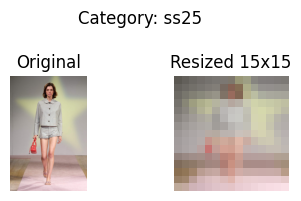

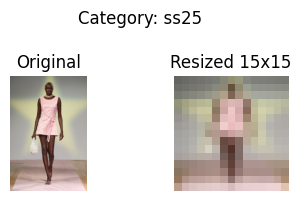

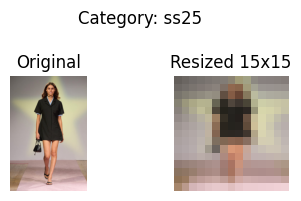

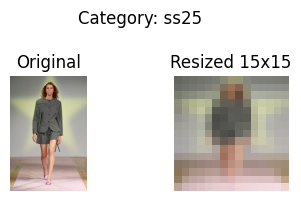

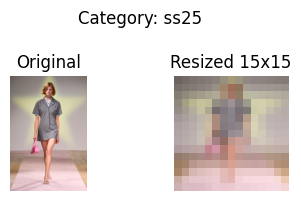

Train shape: (232, 675)
Test shape: (232, 675)
100.0% of test samples were correctly classified


In [3]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt

# define groups

train_categories = ['ss25','ss24','ss23','ss22','ss21','ss20','ss19']
test_categories = ['ss25','ss24','ss23','ss22','ss21','ss20','ss19']
#test_categories = ['ss25']

#test_categories = ['fw25','r25','fw24','r24','fw23','fw22','r22','fw21','r20','fw20','fw19','r19']
# Create label map (shared labels for train/test)
all_categories = sorted(set(train_categories + test_categories))
label_map = {cat: idx for idx, cat in enumerate(all_categories)}

folder = 'images'
image_extensions = ('.jpg')

# visualize 
def load_images(categories, label_map, visualize=False, visualize_limit=5):
    data = []
    labels = []
    visualized = 0

    for category in categories:
        category_path = os.path.join(folder, category)
        if not os.path.exists(category_path):
            print(f"Warning: Category folder '{category_path}' not found. Skipping.")
            continue

        for file in os.listdir(category_path):
            if not file.lower().endswith(image_extensions):
                continue

            img_path = os.path.join(category_path, file)
            try:
                img = imread(img_path)
                resized_img = resize(img, (15, 15), anti_aliasing=True)
                data.append(resized_img.flatten())
                labels.append(label_map[category])

                # Visualize
                if visualize and visualized < visualize_limit:
                    plt.figure(figsize=(4, 2))
                    plt.subplot(1, 2, 1)
                    plt.imshow(img)
                    plt.title("Original")
                    plt.axis('off')

                    plt.subplot(1, 2, 2)
                    plt.imshow(resized_img)
                    plt.title("Resized 15x15")
                    plt.axis('off')

                    plt.suptitle(f"Category: {category}")
                    plt.tight_layout()
                    plt.show()
                    visualized += 1
            except Exception as e:
                print(f"Error reading image {img_path}: {e}")
    
    return np.array(data), np.array(labels)

# create label map
all_categories = sorted(set(train_categories + test_categories))
label_map = {cat: idx for idx, cat in enumerate(all_categories)}

# load data
x_train, y_train = load_images(train_categories, label_map, visualize=True)
x_test, y_test = load_images(test_categories, label_map)

print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

# train classifier
classifier = SVC()
parameters = [{'gamma':[0.01,0.001,0.0001], 'C':[1,10,100,1000]}]
grid_search = GridSearchCV(classifier, parameters)
grid_search.fit(x_train, y_train)

# evaluate
best_estimator = grid_search.best_estimator_
y_prediction = best_estimator.predict(x_test)
score = accuracy_score(y_prediction, y_test)
print('{}% of test samples were correctly classified'.format(str(score*100)))

# save model
pickle.dump(best_estimator, open('./imgclass', 'wb'))


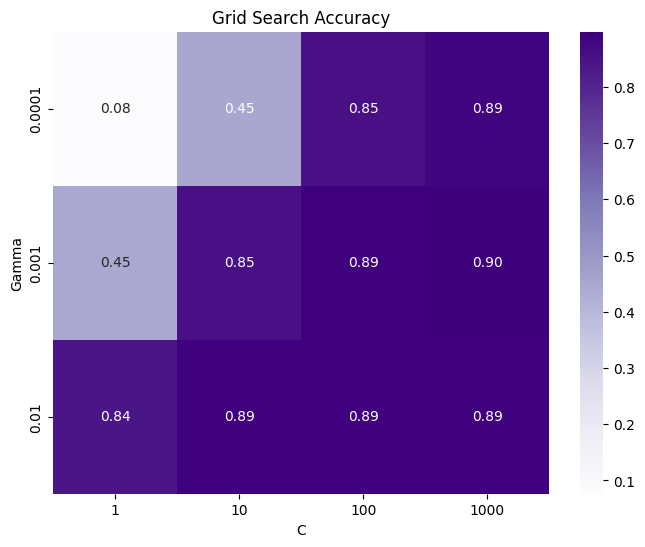

In [76]:
results = pd.DataFrame(grid_search.cv_results_)
pivot = results.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='Purples')
plt.title('Grid Search Accuracy')
plt.xlabel('C')
plt.ylabel('Gamma')
plt.show()


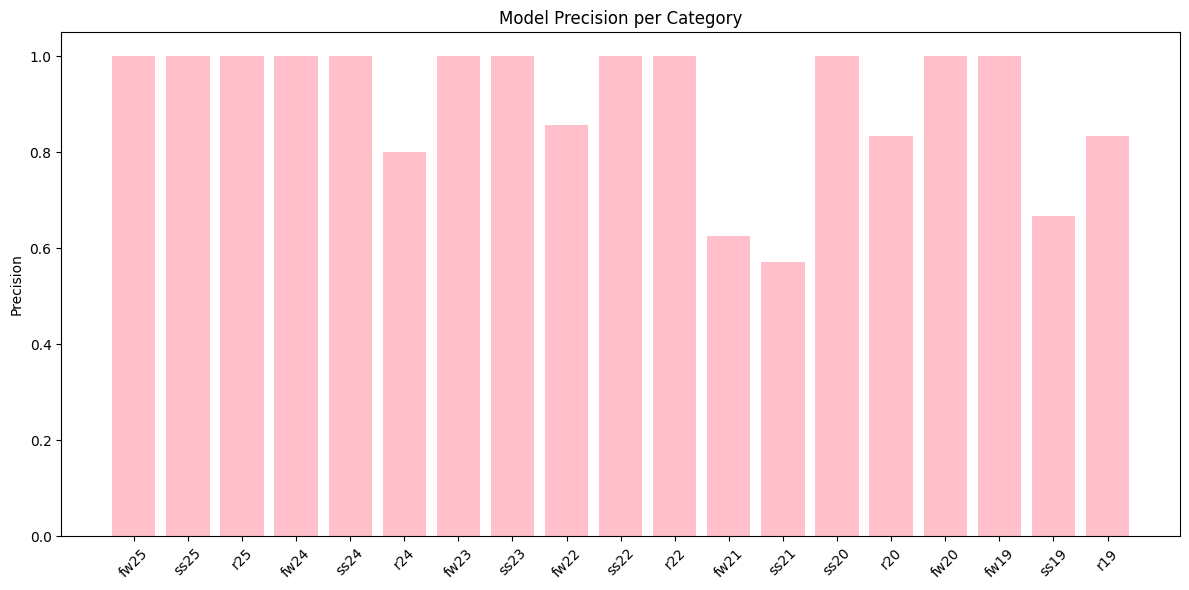

In [78]:
# model precision plot
from sklearn.metrics import classification_report

report = classification_report(y_test, y_prediction, output_dict=True)
accuracies = [report[str(i)]['precision'] for i in np.unique(y_test)]

plt.figure(figsize=(12, 6))
plt.bar([categories[i] for i in np.unique(y_test)], accuracies, color='pink')
plt.xticks(rotation=45)
plt.ylabel("Precision")
plt.title("Model Precision per Category")
plt.tight_layout()
plt.show()


/home/jupyter-cheun23o/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jupyter-cheun23o/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jupyter-cheun23o/.local/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jupyter-cheun23o/.local/lib/python3.12/site-packages/sklear

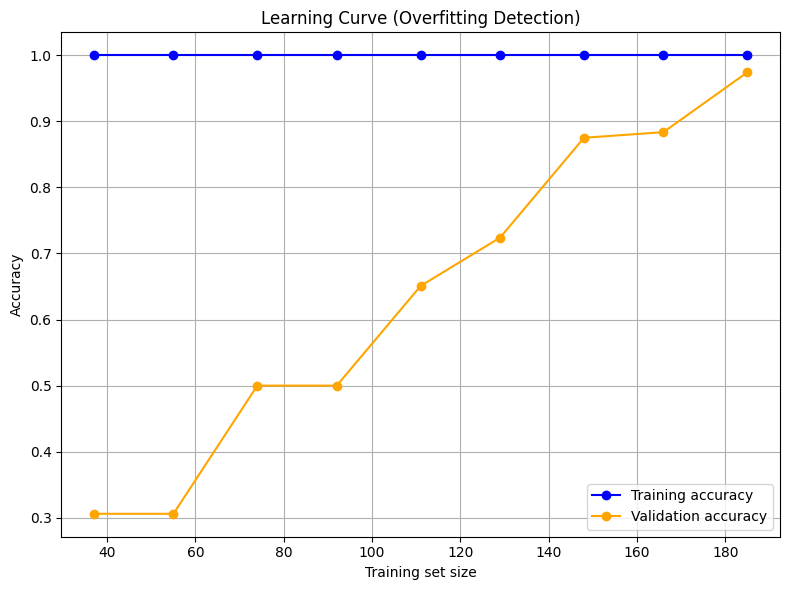

In [13]:
# learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_estimator,  # from GridSearchCV
    X=x_train,
    y=y_train,
    cv=5,                      # 5-fold cross-validation
    train_sizes=np.linspace(0.1, 1.0, 10),  # from 10% to 100% of training data
    scoring='accuracy',
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training accuracy')
plt.plot(train_sizes, test_scores_mean, 'o-', color='orange', label='Validation accuracy')

plt.title('Learning Curve (Overfitting Detection)')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()
